## Theoretical basis for identifying anomalies in Smart Meters.
The determination will be carried out using the clustering method (unsupervised machine learning), 
this method shows high accuracy and the ability to adjust sensitivity.

## Theory:
https://pieriantraining.com/dbscan-for-outlier-detection-in-python-and-scikit-learn-machine-learning-in-python/

https://medium.com/@gabrielpierobon/dbscan-for-anomaly-detection-5457576ef4ad

As test data was taken dataset from Kaggle, which represents a recording of a real smartmeter data: 
https://www.kaggle.com/datasets/portiamurray/anomaly-detection-smart-meter-data-sample/data

## Code:

In [7]:
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import random
import collections as cl

In [8]:
data = pd.read_excel("data/Lastgang Elektroverbruche 160101-170511.xlsx")

In [9]:
data.head()

,Datum Zeit,Messung Gebäude 2ewz [kWh]
0,2016-01-01 00:15:00,2.85
1,2016-01-01 00:30:00,2.85
2,2016-01-01 00:45:00,3.00
3,2016-01-01 01:00:00,2.94
4,2016-01-01 01:15:00,2.79


Clean dataset and preparation of data:

In [10]:
data.columns = ['datetime','kWh']

# make datetimestamp as th index in the original dataset
data = data.set_index('datetime')

# delete duplicates from dataset
data = data[~data.index.duplicated(keep='first')]

/tmp/ipykernel_173689/2003397023.py:12: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


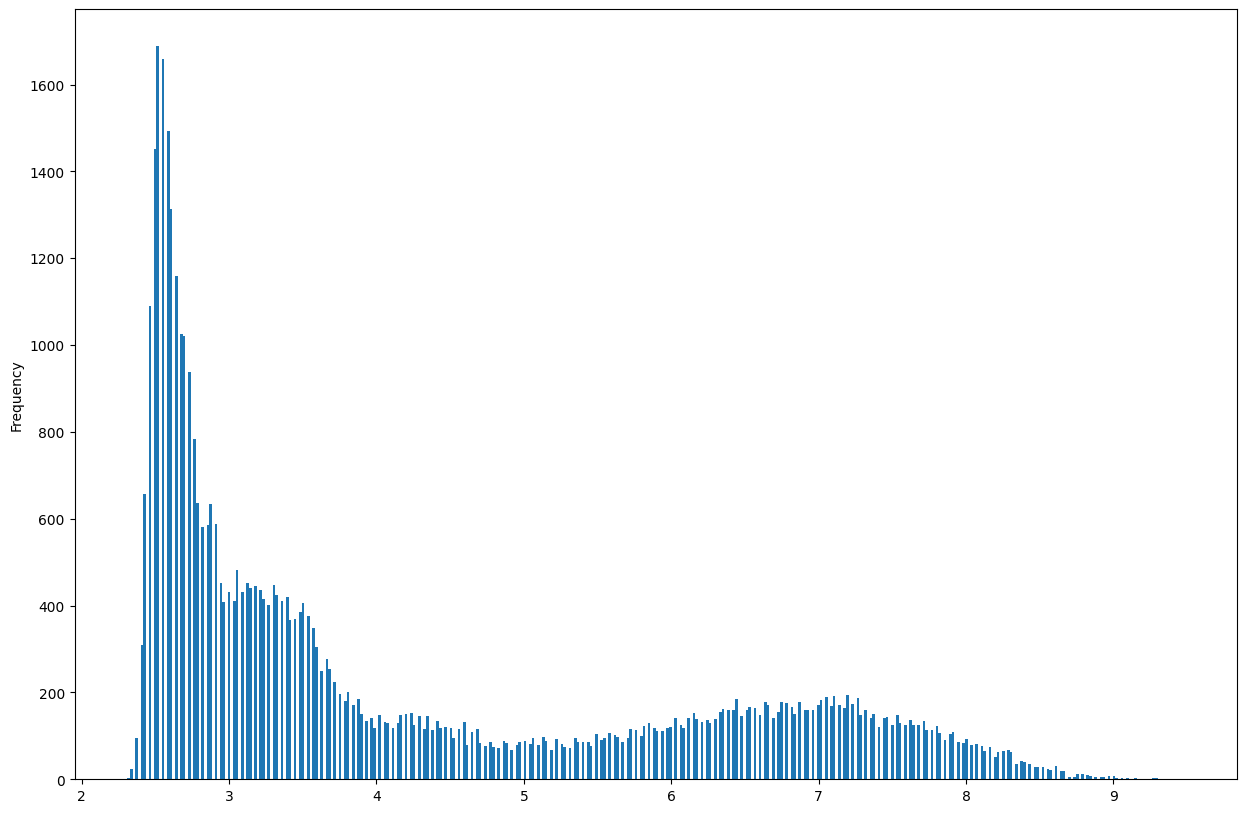

In [11]:
# plot graph, number of values/consumption

plt.rcParams['figure.figsize'] = [15, 10] # plot size width and height
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.set_facecolor('#FFFFFF')
ax.set_xlabel('kWh')
ax.set_ylabel('Frequency')
ax.tick_params(colors='k')
ax.yaxis.label.set_color('k')
ax.xaxis.label.set_color('k')
data['kWh'].plot(kind = 'hist', bins = 400)
fig.show()

The graph shows that most of the values are distributed between 2.5 and 7

In [12]:
# Prepare data
# this is a function that generates timestamps from START to END with the step of DELTA

def datetime_range(start, end, delta):
    current = start
    while current < end:
        yield current
        current += delta

# Find the START and END from the dataset, i.e., the first and the last datestamps.
START, END = data.index[0], data.index[-1]

In [13]:
# generate timestamps for the whole period with the function datetime_range starting on START, ending on END. The delta is equal to 15 minutes
# construct a dataframe indexed by the timestamps
df = pd.DataFrame(datetime_range(START, END, timedelta(minutes=15)))
df.columns = ['datetime']
df['kWh'] = np.nan
df = df.set_index('datetime')
df.head()

,kWh
datetime,
2016-01-01 00:15:00,NaN
2016-01-01 00:30:00,NaN
2016-01-01 00:45:00,NaN
2016-01-01 01:00:00,NaN
2016-01-01 01:15:00,NaN


In [14]:
# fill in the DF dataset with values from the original dataset DATA, output a message if the value is missing
for index,row in df.iterrows():
    if index in data.index:
        df.loc[index]['kWh'] = data.loc[index]['kWh']
    else:
        pass

/tmp/ipykernel_173689/1744535330.py:4: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df.loc[index]['kWh'] = data.loc[index]['kWh']


In [15]:
# create dataset with column "day", "weekday", "workday" and "hour"
df.reset_index(inplace = True)
df['date'] = df.apply(lambda row: row['datetime'].date(), axis = 1)
df['weekday'] = df.apply(lambda row: row['datetime'].weekday(), axis = 1)
df['workday'] = df.apply(lambda row: row['weekday'] < 5, axis = 1)
df['hour'] = df.apply(lambda row: row['datetime'].hour, axis = 1)

In [16]:
df.head()

,datetime,kWh,date,weekday,workday,hour
0,2016-01-01 00:15:00,2.85,2016-01-01,4,True,0
1,2016-01-01 00:30:00,2.85,2016-01-01,4,True,0
2,2016-01-01 00:45:00,3.00,2016-01-01,4,True,0
3,2016-01-01 01:00:00,2.94,2016-01-01,4,True,1
4,2016-01-01 01:15:00,2.79,2016-01-01,4,True,1


<Axes: xlabel='weekday'>

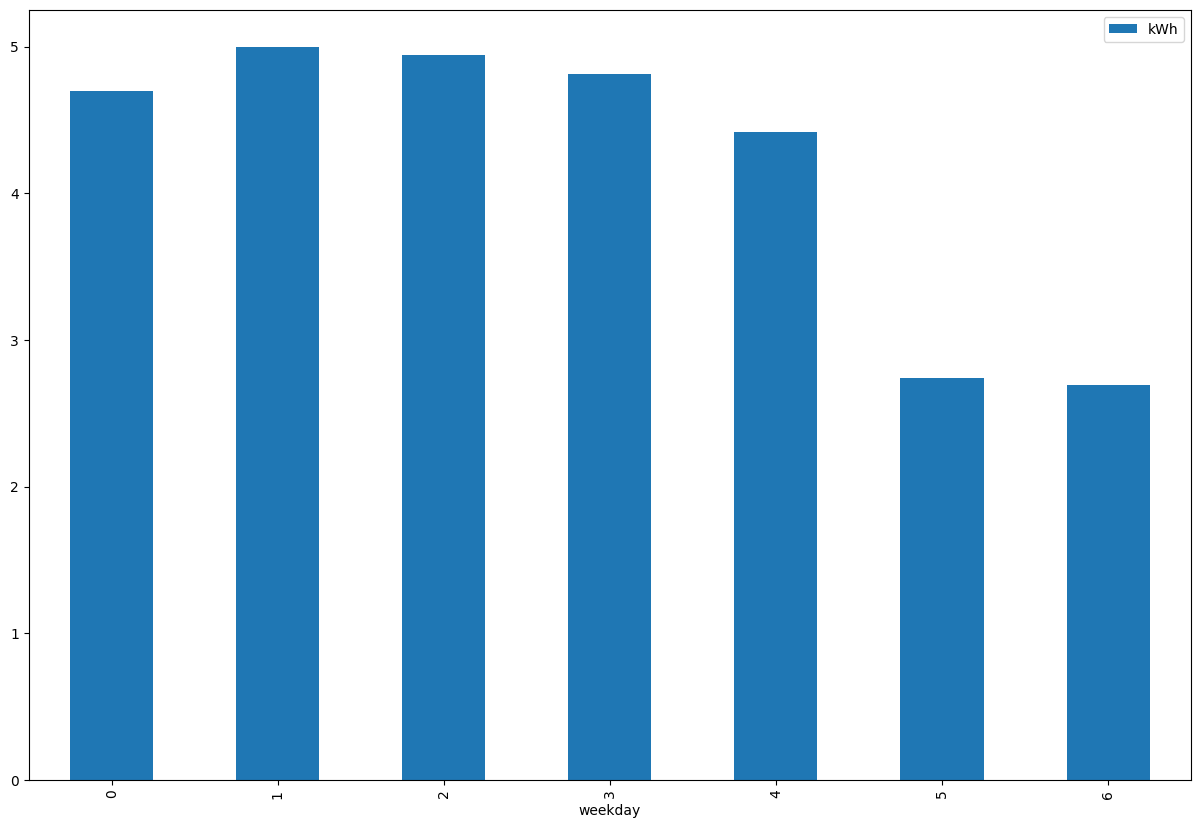

In [17]:
# graph distrubution by day
weekday_labels = ['Mo','Tu','We','Th','Fr','Sa','Su']

# distribution consumption by day
df[['weekday', 'kWh']].groupby(['weekday']).mean().plot(kind = 'bar')

In [18]:
df['hour'] = df.apply(lambda row: row['datetime'].hour, axis=1)

<Axes: xlabel='hour'>

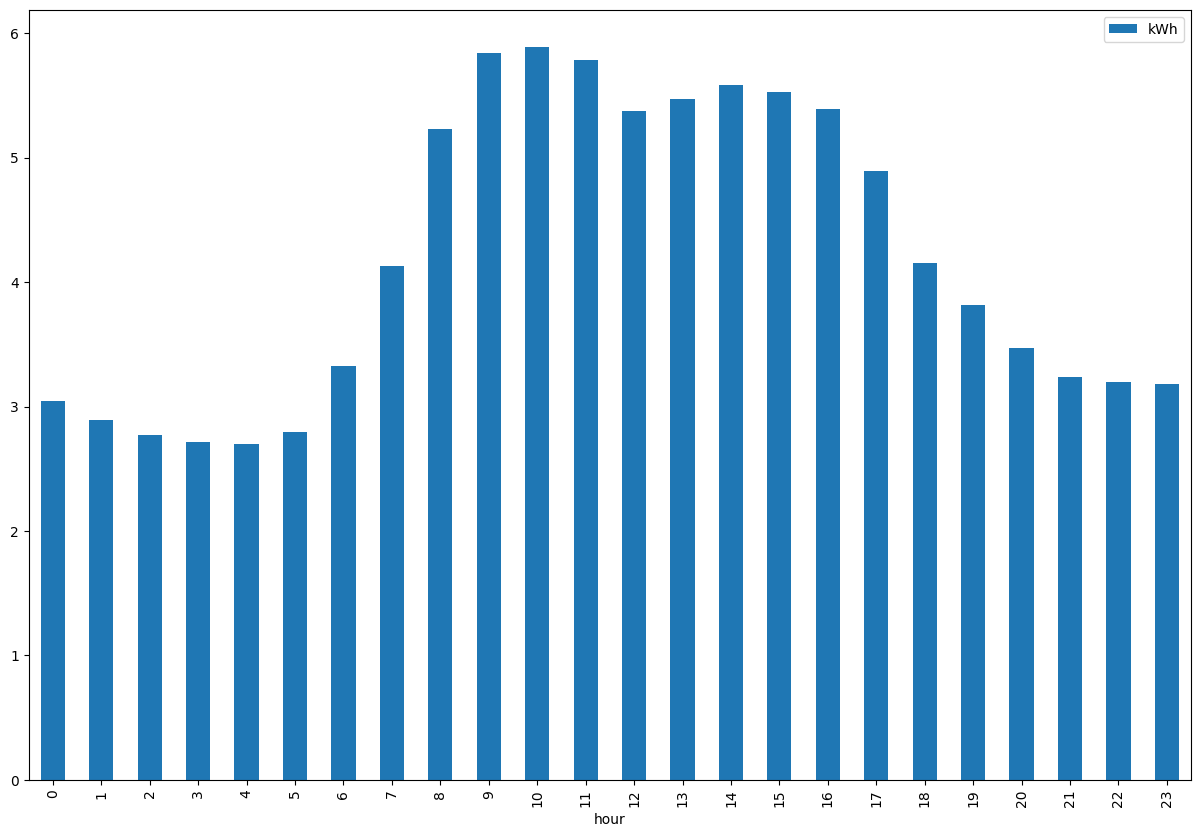

In [19]:
# distribution consumption by hours
df[['hour', 'kWh']].groupby(['hour']).mean().plot(kind = 'bar')

In [20]:
df['month'] = df.apply(lambda row: row['datetime'].month, axis=1)

<Axes: xlabel='month'>

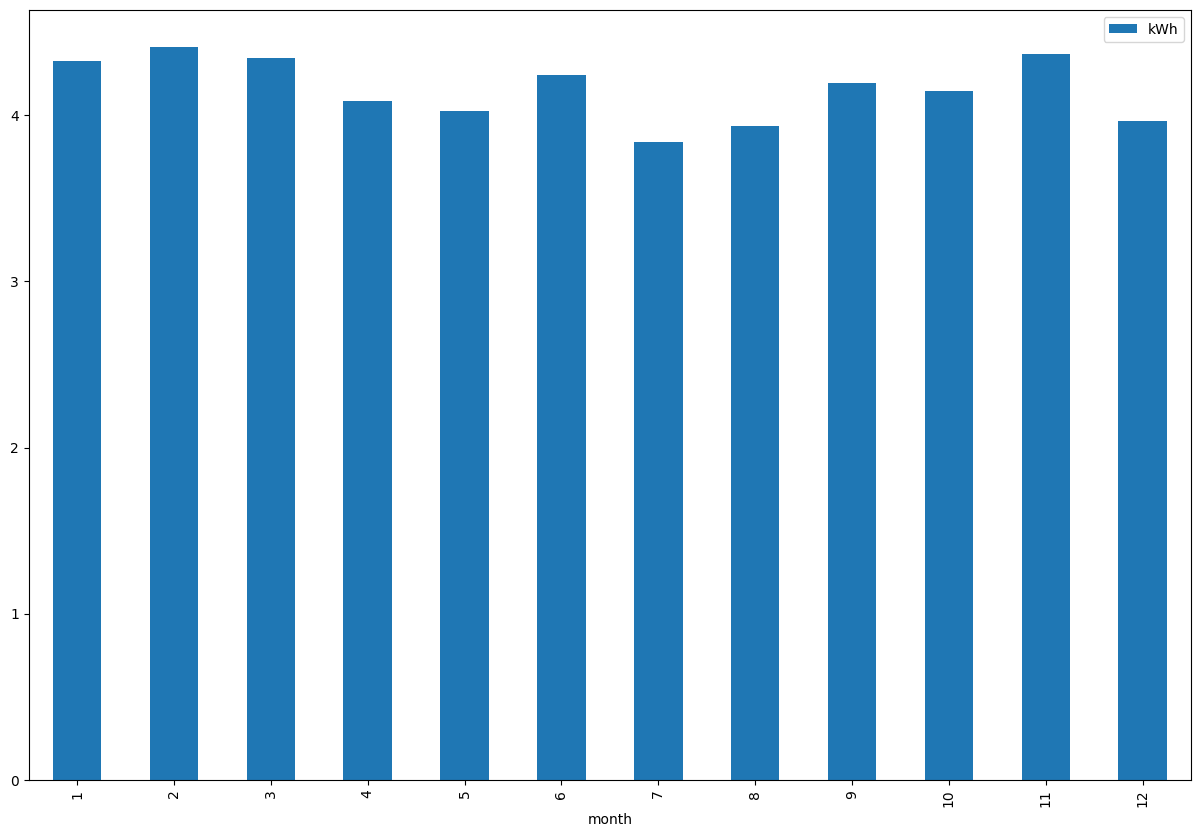

In [21]:
# distribution consumption by month
df[['month', 'kWh']].groupby(['month']).mean().plot(kind = 'bar')

In [22]:
df_day_hour = df[['weekday','hour', 'kWh']].groupby(['weekday','hour']).mean()
df_day_hour.reset_index(inplace = True)
df_day_hour

,weekday,hour,kWh
0,0,0,2.720810
1,0,1,2.661761
2,0,2,2.632923
3,0,3,2.596901
4,0,4,2.585176
...,...,...,...
163,6,19,2.722394
164,6,20,2.718592
165,6,21,2.760845
166,6,22,2.764648


## Consumption on weekends by hour

/tmp/ipykernel_173689/3873920634.py:12: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


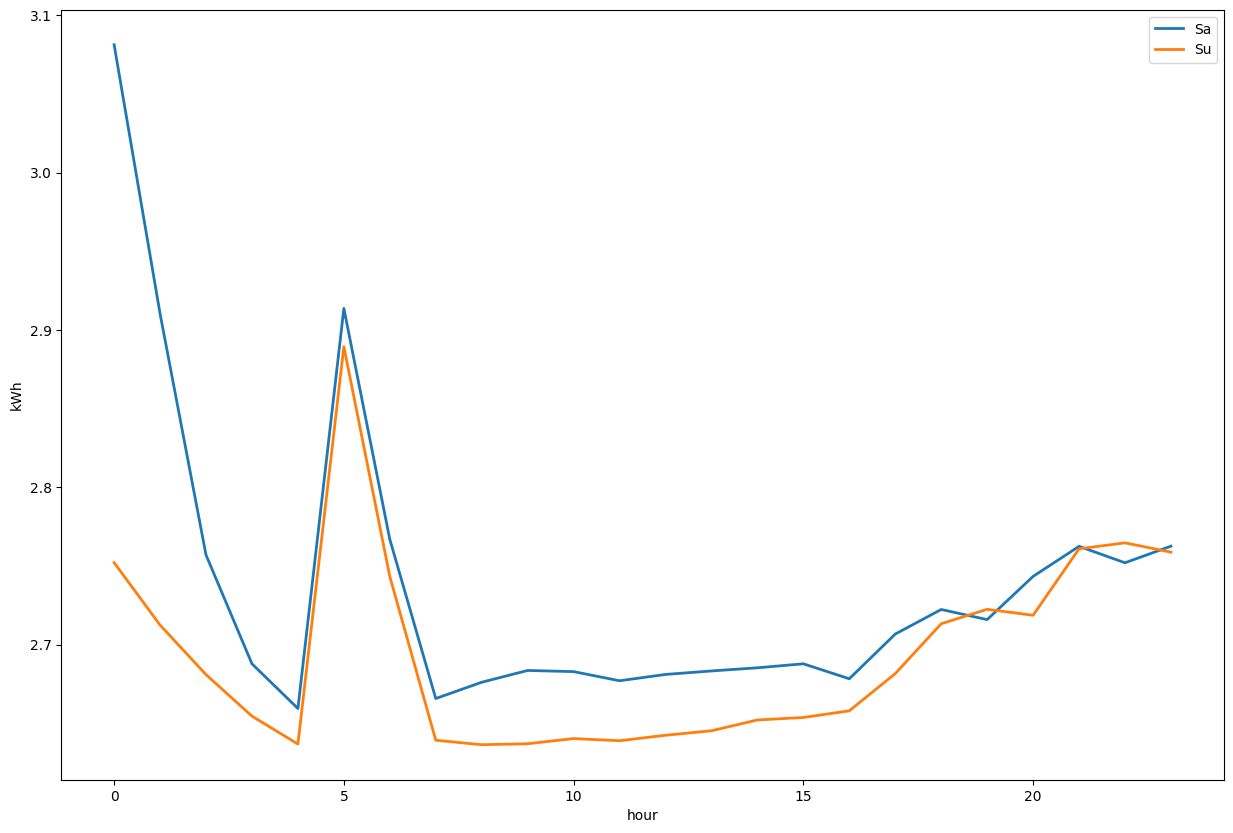

In [23]:
plt.rcParams['figure.figsize'] = [15, 10] # plot size width and height
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.set_facecolor('#FFFFFF')
ax.set_xlabel('hour')
ax.set_ylabel('kWh')
ax.tick_params(colors='k')
ax.yaxis.label.set_color('k')
ax.xaxis.label.set_color('k')
for idx in range(5,7):
    plt.plot(df_day_hour[df_day_hour['weekday'] == idx]['hour'],df_day_hour[df_day_hour['weekday'] == idx]['kWh'], linewidth=2, label = weekday_labels[idx])
plt.legend()
fig.show()

## Consumption on workdays by hour

/tmp/ipykernel_173689/541639209.py:12: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


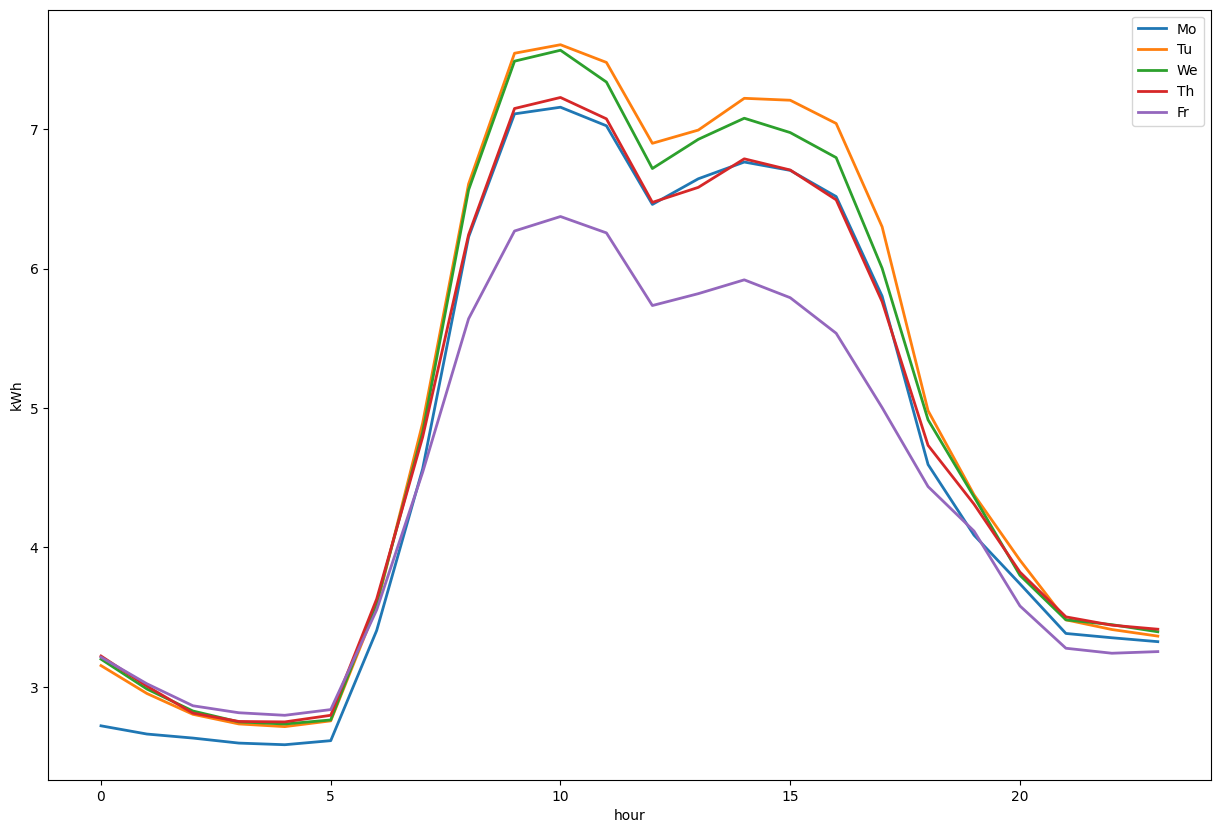

In [24]:
plt.rcParams['figure.figsize'] = [15, 10] # plot size width and height
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.set_facecolor('#FFFFFF')
ax.set_xlabel('hour')
ax.set_ylabel('kWh')
ax.tick_params(colors='k')
ax.yaxis.label.set_color('k')
ax.xaxis.label.set_color('k')
for idx in range(5):
    plt.plot(df_day_hour[df_day_hour['weekday'] == idx]['hour'],df_day_hour[df_day_hour['weekday'] == idx]['kWh'], linewidth=2, label = weekday_labels[idx])
plt.legend()
fig.show()

## Clustering by day

In [25]:
f = {'kWh': ['mean', 'std'], 'workday': 'mean', 'weekday': ['mean'], 'month':'mean'}
df_day = df.groupby('date').agg(f)

In [26]:
df_day = df_day.dropna()
df_day

kWh           workday weekday month
                mean       std    mean    mean  mean
date                                                
2016-01-01  2.754000  0.087585     1.0     4.0   1.0
2016-01-02  2.723125  0.036283     0.0     5.0   1.0
2016-01-03  2.725938  0.035528     0.0     6.0   1.0
2016-01-04  5.222500  2.211100     1.0     0.0   1.0
2016-01-05  5.040938  2.022156     1.0     1.0   1.0
...              ...       ...     ...     ...   ...
2017-05-06  3.014375  0.089099     0.0     5.0   5.0
2017-05-07  3.027813  0.083982     0.0     6.0   5.0
2017-05-08  5.157812  2.043110     1.0     0.0   5.0
2017-05-09  5.167500  1.916844     1.0     1.0   5.0
2017-05-10  4.946250  1.681591     1.0     2.0   5.0

[496 rows x 5 columns]

In [27]:
df_day.columns = ['kWh-mean', 'kWh-std', 'workday', 'weekday','month']

## The graph below shows consumption by day, there are two clusters, blue is consumption on weekdays, and green consumption is on non-workdays, red is outliers, anomalous behavior

In [28]:
X = df_day[['kWh-mean','kWh-std']]
X = StandardScaler().fit_transform(X)

In [29]:
# esp defines the maximum distance allowed between two points within the same cluster
# min_samples defines the minimum number of data points in the cluster

db = DBSCAN(eps = 0.20, min_samples = 3).fit(X)
for l in set(db.labels_):
    print('The number of day labeled ', l, ' is ', sum(db.labels_ == l))

The number of day labeled  0  is  152
The number of day labeled  1  is  337
The number of day labeled  2  is  3
The number of day labeled  -1  is  4


In [30]:
df_day['DB-label'] = db.labels_

/tmp/ipykernel_173689/1595312813.py:12: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


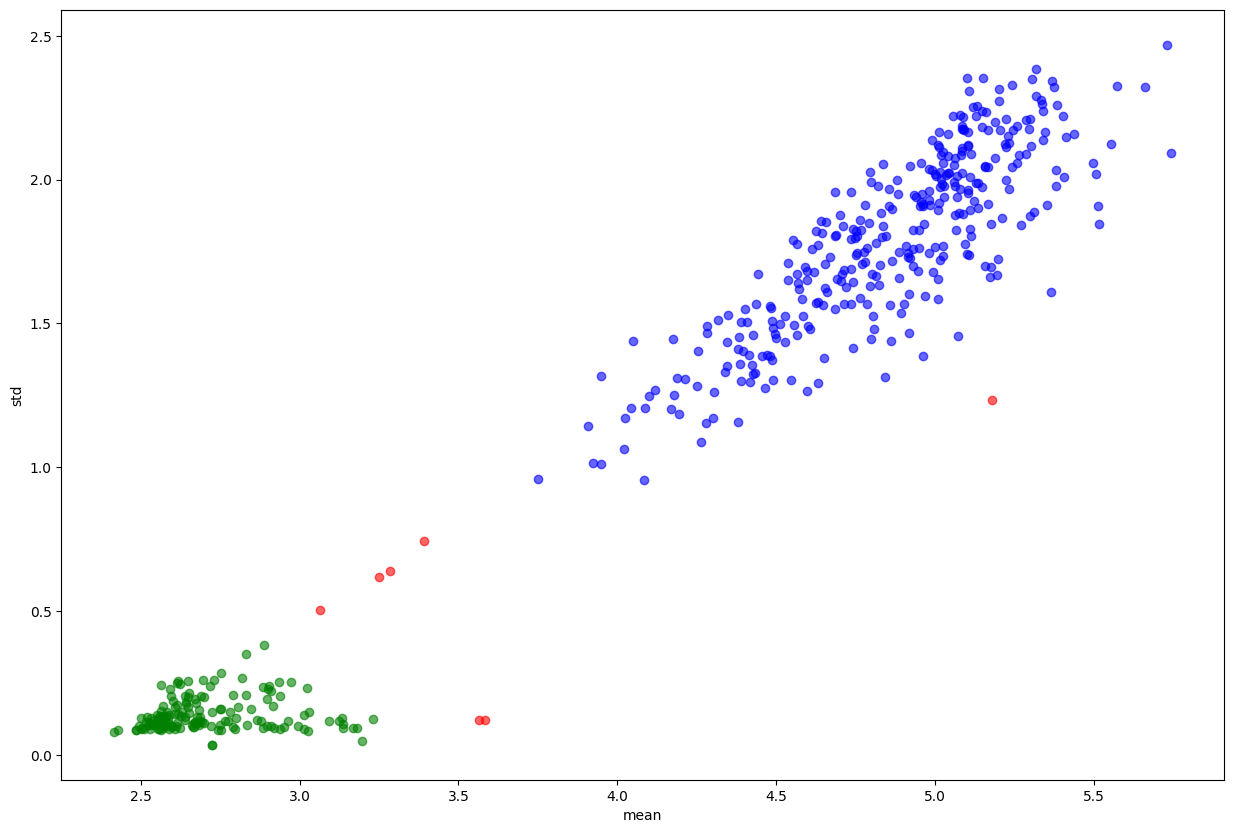

In [31]:
plt.rcParams['figure.figsize'] = [15, 10] # plot size width and height
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.set_facecolor('#FFFFFF')
ax.set_xlabel('mean')
ax.set_ylabel('std')
ax.tick_params(colors='k')
ax.yaxis.label.set_color('k')
ax.xaxis.label.set_color('k')
plt.plot(df_day[df_day['DB-label']==0]['kWh-mean'], df_day[df_day['DB-label']==0]['kWh-std'], 'go', alpha = 0.6)
plt.plot(df_day[df_day['DB-label']==1]['kWh-mean'], df_day[df_day['DB-label']==1]['kWh-std'], 'bo', alpha = 0.6)
plt.plot(df_day[~(df_day['DB-label']==0) & ~(df_day['DB-label']==1)]['kWh-mean'], df_day[~(df_day['DB-label']==0) & ~(df_day['DB-label']==1)]['kWh-std'], 'ro', alpha = 0.6)
fig.show()

## Show all anomalies:

In [32]:
df_day_outliers = df_day[~(df_day['DB-label']==1) & ~(df_day['DB-label']==0)]
df_day_outliers.reset_index(inplace = True)
df_day_outliers

,date,kWh-mean,kWh-std,workday,weekday,month,DB-label
0,2016-05-06,3.390313,0.743925,1.0,4.0,5.0,2
1,2016-12-27,3.283125,0.641051,1.0,1.0,12.0,2
2,2016-12-28,3.249375,0.619488,1.0,2.0,12.0,2
3,2016-12-29,3.063125,0.503193,1.0,3.0,12.0,-1
4,2017-02-11,3.582187,0.122313,0.0,5.0,2.0,-1
5,2017-02-12,3.565625,0.122962,0.0,6.0,2.0,-1
6,2017-02-24,5.178182,1.234611,1.0,4.0,2.0,-1


In [33]:
num_outliers = len(df_day_outliers)
num_outliers

7

So we have 7 anomalous points, let’s consider the behavior of each of these points

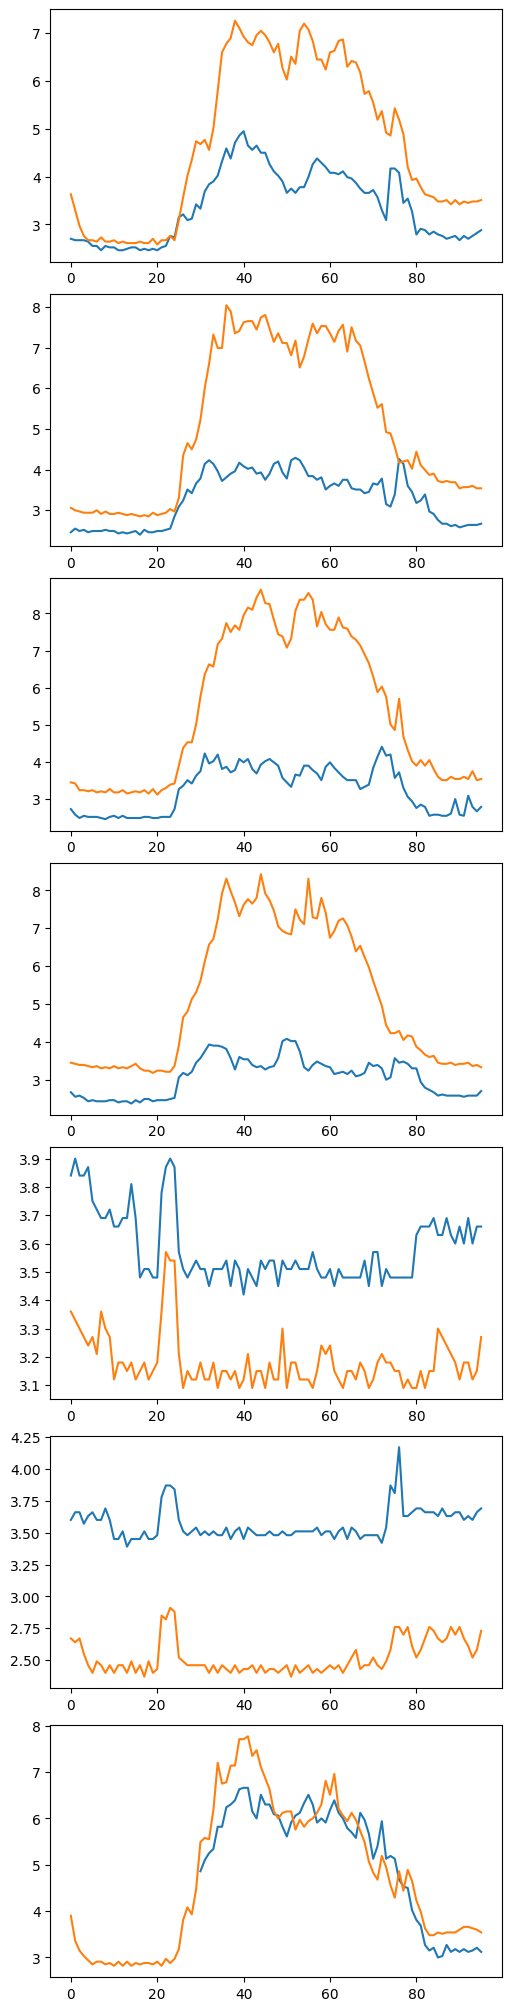

In [35]:
plt.rcParams['figure.figsize'] = [5, 20] # plot size width and height

fig, ax = plt.subplots(nrows=num_outliers, ncols=1, constrained_layout=True)

for ido, row in enumerate(ax):
    # what day of the week it is
    wd = int(df[df['date'] == df_day_outliers.iloc[ido]['date']]['weekday'].max())
    # find index of a random day with the same weekday value
    l = len(df[df['weekday'] == wd])
    idr = random.randint(0,l-1)
    idr_date = df[df['weekday'] == wd].iloc[idr]['date']
    row.plot(df[df['date'] == df_day_outliers.iloc[ido]['date']].reset_index()['kWh'])
    row.plot(df[df['date'] == idr_date].reset_index()['kWh'])
    

plt.show()

here blue is a day of abnormal behavior, and orange is a random day with “normal” behavior. As we can see, abnormal behavior is very different from normal; in the last graph, the consumption of the abnormal graph is zero for some time, obviously this classifies it as abnormal